<a href="https://colab.research.google.com/github/StephenSpicer/Unit_02_Clone/blob/master/Stephen_Lupsha_DS23_Sprint_Challenge_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders`.

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders

 
# Sprint Challenge: Predict Steph Curry's Shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts from October 2009 through June 2019 (regular season and playoffs). The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

You'll create a model to predict whether Curry will make a shot based on his past perfomance.

# Directions

This notebook contains 10 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Feature engineering.
- **Task 3:** Splitting data into a feature matrix and target vector.
- **Task 4:** Splitting data into training, validation, and test sets.
- **Task 5:** Establishing baseline accuracy.
- **Task 6:** Building a model with a transformer and a tree-based predictor.
- **Task 7:** Calculating training and validation accuracy.
- **Task 8 (`stretch goal`):** Tuning model hyperparameters.
- **Task 9:** Calculating precision and recall from a confusion matrix.
- **Task 10 (`stretch goal`):** Plotting a confusion matrix.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise 
NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `sklearn`



In [2]:
# PREAMBLE - we hold these packages to be self evident. 
# thank god for those who came before us, we stand on their shoulders. 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import seaborn as sns

# that takes care of the basics now for the sci-kit

import category_encoders as ce
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set at the index. 

In [3]:
def wrangle(df):
  # We know it's steph curry, I think we can drop that. 
  df = df.copy()

  df.drop(columns=['player_name'], inplace=True)

  df['seconds_remaining_inperiod'] = df['minutes_remaining'] + df['seconds_remaining']
  df['seconds_remaining_ingame'] = df['seconds_remaining_inperiod'] + df['period']
  df['homecourt_adv'] = df['htm'] == 'GSW'
  
  
  return df

In [4]:
'''T1. Import DataFrame `df`'''


url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url,
                 parse_dates=['game_date'],
                 index_col='game_date')

df = wrangle(df)


In [5]:
df.head()

,game_id,game_event_id,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot,seconds_remaining_inperiod,seconds_remaining_ingame,homecourt_adv
game_date,,,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0,36,37,True
2009-10-28,20900015,17,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0,40,41,True
2009-10-28,20900015,53,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0,8,9,True
2009-10-28,20900015,141,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.0,58,60,True
2009-10-28,20900015,249,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.0,21,23,True


In [6]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

**Task 1 Testing**

In [7]:
'''T1 Testing'''

assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 13958, 'Is `df` the correct length?'


**Task 2a:** Engineer at least 1 new feature. You can use something from the list below or your own idea.

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**Task 2b (`stretch goal — optional`):** Create a total of 3 new features, using your own ideas or the list above. Make sure you're not just duplicating features that are already in the feature matrix.

In [8]:
"""T2. Create new feature"""

  # df['seconds_remaining_inperiod'] = df['minutes_remaining'] + df['seconds_remaining']
  # df['seconds_remaining_ingame'] = df['seconds_remaining_inperiod'] + df['period']
  # df['homecourt_adv'] = df['htm'] == 'GSW'

'T2. Create new feature'

**Task 2 Test**

In [9]:
'''T2 Testing'''

assert df.shape[1] >= 20, '`df` does not appear to have new features.'


# II. Split Data

**Task 3:** Divide the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'shot_made_flag'`.

In [10]:
'''T3. Create `X` and `y`.'''

# target
target = 'shot_made_flag'
#feature matrix
X = df.drop(columns=target)
# target vector
y = df[target]

print('features matrix shape: ', X.shape)
print()
print( 'target vector shape: ', y.shape)

features matrix shape:  (13958, 20)

target vector shape:  (13958,)


**Task 3 Test**

In [11]:
'''T3 Tests'''

assert y.shape == (13958,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 13958, '`X` has the wrong number of rows.'
assert X.shape[1] > 1, '`X` has the wrong number of columns'
assert 'shot_made_flag' not in X.columns, 'Target is still part of feature matrix.' 

**Task 4:** Divide your dataset into training, validation, and test sets. 

- Your training set (`X_train`, `y_train`) should contain games from the 2009-10 season through the end of the 2016-17 season.
- Your validation set (`X_val`, `y_val`) should contain games from the 2017-18 season.
- Your test set (`X_test`, `y_test`) should contain games from the 2018-2019 season.
- **Tip:** The NBA season begins in October and ends in June.

In [13]:
'''T4. Create training and val'''

cutoff = '2017-06-18'
cutoff_val = '2018-06-18'

mask_train = X.index < cutoff
mask_val = (X.index > cutoff) & (X.index < cutoff_val)
mask_test = X.index > cutoff_val

X_train, y_train = X.loc[mask_train], y.loc[mask_train]
X_val, y_val = X.loc[mask_val], y.loc[mask_val]
X_test, y_test = X.loc[mask_test], y.loc[mask_test]


#let's get some shapes
print('X_Train Shape:', X_train.shape,'y_train Shape:', y_train.shape) 
print()
print('X_val Shape:', X_val.shape, 'y_val Shape:', y_val.shape)
print()
print('X_test shape: ', X_test.shape, 'y_test shape: ', y_test.shape)

X_Train Shape: (11081, 20) y_train Shape: (11081,)

X_val Shape: (1168, 20) y_val Shape: (1168,)

X_test shape:  (1709, 20) y_test shape:  (1709,)


**Test 4**

In [14]:
'''T4 Tests'''
assert len(X_train) == len(y_train) == 11081
assert len(X_val) == len(y_val) == 1168
assert len(X_test) == len(y_test) == 1709


# III. Establish Baseline

**Task 5:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [15]:
'''T5. Calculate baseline accuracy `baseline_acc`.'''

baseline_acc = df['shot_made_flag'].value_counts(normalize=True).max()

print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5270812437311936


**Task 5 Testing**

In [16]:
'''T5 Testing'''

assert isinstance(baseline_acc, float)
assert 0.0 <= baseline_acc <= 1.0


# IV. Build Model

**Task 6:** Build a model that includes (1) a transformer for categorical features and (2) a tree-based predictor. You should combine these two components (and any other pieces you think are necessary) in a pipeline named `model`. Be sure to fit your model to your training data.

In [76]:
'''T6. Build a pipeline `model` with encoder and tree-based predictor.'''
model = make_pipeline(
    #FunctionTransformer(wrangle, validate=False), 
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))


Validation Accuracy 0.5958904109589042


**Task 6 Testing**

In [25]:
'''T6 Testing'''

from sklearn.pipeline import Pipeline
assert isinstance(model, Pipeline), '`model` should be type `Pipeline`.'

# Does `model` Pipeline have multiple components?
assert len(model.named_steps.keys()) > 1, '`model` should have more than one component.'

# Has `model` been trained?
assert hasattr(model, 'classes_'), 'Have you trained `model`?'


# V. Check Metrics

**Task 7:** Check the training and validation accuracy of your model, and assign the scores to `train_acc` and `val_acc` respectively.

In [31]:
'''T7. Calculate train and test accuracy.'''

train_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)

print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 1.0
Validation Accuracy Score: 0.5958904109589042


**Task 7 Test**

In [34]:
'''T7 Testing'''

# Is `training_acc` a float between 0.0 and 1.0?
assert isinstance(train_acc, float)
assert 0.0 <= train_acc <= 1.0

# Is `validation_acc` a float between 0.0 and 1.0?
assert isinstance(val_acc, float)
assert 0.0 <= val_acc <= 1.0


# VI. Tune Model

**Task 8 (`stretch goal — optional`):** Using your training and validation sets as a guide, tune the hyperparameters of your model to see if you can improve its accuracy. You can perform your tuning "by hand" or using [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

- Important hyperparameters for all tree-based models: `max_depth`.
- Important hyperparameters for random forest models: `n_estimators`, `max_samples`. 
- Important hyperparametes for gradient boosting tree models: `n_estimators`, `learning_rate`.
- **TIP:** If you use `RandomizedSearchCV`, set `n_iter` to `3`. Any larger and the auto-grader will stop working.
- **TIP:** Since you already created a validation set above, there is no need to do k-fold cross-validation here. Set `cv` to `None`.

Once you're satisfied with your model's performance on the validation set (if you can get above `0.6`, you're doing good), calculate its accuracy with your test set. Assign the result to `test_acc`.

In [40]:
X_test.shape

(1709, 20)

In [92]:
'''T8. Tune model.'''
paras = {'randomforestclassifier__n_estimators': np.arange(2, 20, 2), 
         'randomforestclassifier__max_depth': np.arange(10, 21, 2),
         'randomforestclassifier__max_samples': np.arange(0.1, .8, 0.1),
         'randomforestclassifier__max_features': np.arange(12, 24, 2)}

rf_rs = RandomizedSearchCV(model, param_distributions=paras, n_iter=3, cv=None, n_jobs=-1, verbose=1)
rf_rs.fit(X_train, y_train)



Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    4.0s finished
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['action_type',
                                                                   'shot_type',
                                                                   'shot_zone_basic',
                                                                   'shot_zone_area',
                                                                   'shot_zone_range',
                                                                   'htm', 'vtm',
                                                                   'season_type'],
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
    

In [86]:
rf_rs.best_params_

{'randomforestclassifier__max_depth': 16,
 'randomforestclassifier__max_features': 14,
 'randomforestclassifier__max_samples': 0.30000000000000004,
 'randomforestclassifier__n_estimators': 8}

In [94]:
rf_rs.score(X_train, y_train)

0.7520981860842885

In [95]:
rf_rs.score(X_val, y_val)

0.598458904109589

In [96]:
test_acc = rf_rs.score(X_test, y_test)

print(test_acc)

0.6073727325921592


**Task 8 Testing**

In [97]:
'''T8 Testing'''
assert isinstance(test_acc, float)
assert 0.0 <= test_acc <= 1.0

# VII. Communication

**Task 9:** Below is a confusion matrix for the model that your instructor made for this challenge (based on the **test data**). Calculate the precision and recall of this model, naming them `instructor_precision` and `instructor_recall`, respectively.

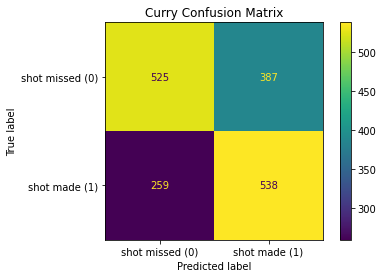

In [61]:
'''T9. Calculate precision and recall'''

instructor_precision = 538/(538+387)
instructor_recall = 538/(538+259)

print('Instuctor model precision', instructor_precision)
print('Instuctor model recall', instructor_recall)

Instuctor model precision 0.5816216216216217
Instuctor model recall 0.6750313676286073


**Task 9 Testing**

In [63]:
'''T9 Testing'''
assert isinstance(instructor_precision, float)
assert isinstance(instructor_recall, float)
assert 0 <= instructor_precision <= 1
assert 0 <= instructor_recall <= 1

**Task 10 (`stretch goal — optional`):** Plot confusion matrix for your model using your **test data**. Does your model have higher recall or higher precision? How does your model's metrics compare to the metrics you calculated above?

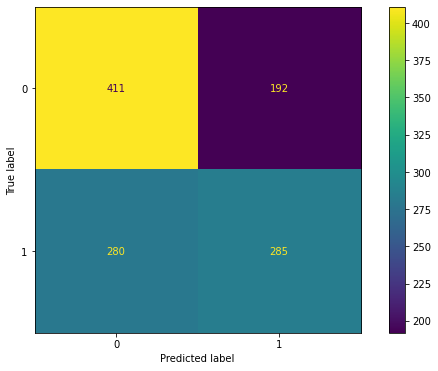

In [98]:
'''T10. Plot ROC curve.'''


from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_val, y_val, values_format='.0f')

In [100]:
# if i ever write a book about learning modeling...
# ...I'm going to title it 'The Confusion Matrix'. 

my_precision = 285/(285+192)
my_recall = 285/(285+280)

print(' model precision', my_precision)
print(' model recall', my_recall)

 model precision 0.5974842767295597
 model recall 0.504424778761062


# I have higher precision than recall. 

## I feel like I could have done much better on this, but I spent way too much time reading about how to reference datetime formats - hyphens not dots - and how to set up > < - turns out parenthesis are our friends, as usual. 

anyways, moving on to the questions...